# 어레이 모양 그림 그리기

참고: [(stackoverflow) How to draw images visualizing numpy arrays themselves?](https://stackoverflow.com/questions/77732026/how-to-draw-images-visualizing-numpy-arrays-themselves)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox

In [2]:
def square(i, j, k, origin=(0,0), zstep=0.2, **kwargs):
    xy = np.array(origin) + np.array((k, j)) + np.array([1, -1]) * i * zstep
    return Rectangle(xy, 1, 1, zorder=-i, **kwargs)

In [3]:
def draw(a, *, 
         origin=(0,0), 
         zstep=0.2,
         ax=None,
         rect_kwargs=None,
         text_kwargs=None):
    
    ax = plt.gca() if ax is None else ax
    
    rect_kwargs = {} if rect_kwargs is None else rect_kwargs
    
    facecolor = rect_kwargs.pop('facecolor', 'lightblue')
    facecolor = np.broadcast_to(facecolor, a.shape)
    
    text_kwargs = {} if text_kwargs is None else text_kwargs
    
    textcolor = rect_kwargs.pop('color', 'k')
    textcolor = np.broadcast_to(textcolor, a.shape)
    
    text_kwargs = dict(ha='center', va='center') | text_kwargs
    
    im, jm, km = a.shape
    
    bboxes = []
    origin = np.array(origin) + np.array((0, zstep * im))
    
    for i in range(im):
        for j in range(jm):
            for k in range(km):
                r = square(i, j, k, origin=origin, edgecolor='k',
                           facecolor=facecolor[i, j, k], **rect_kwargs)
                ax.add_patch(r)
                bb = r.get_bbox()
                bboxes.append(bb)
                center = bb.get_points().mean(0)
                ax.annotate(a[i, j, k], center, **text_kwargs, zorder=-i)
    
    bb = Bbox.union(bboxes)
    
    # help auto axis limits
    ax.plot(*bb.get_points().T, '.', alpha=0)
    
    return bb

In [4]:
def np_example(shape):
    return 1 + np.arange(np.prod(shape)).reshape(shape)

In [5]:
np_example((2, 3, 4))

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]],

       [[13, 14, 15, 16],
        [17, 18, 19, 20],
        [21, 22, 23, 24]]])

In [6]:
np_example((2, 2, 4))

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8]],

       [[ 9, 10, 11, 12],
        [13, 14, 15, 16]]])

**예제 1**

다음 세 개의 어레이를 그린다.

In [7]:
a, b = [np_example(shape) for shape in [(2, 3, 4), (2, 2, 4)]]
c = np.concatenate((a, b), axis=1)

- 왼쪽 상단: 어레이 `a`
- 왼쪽 하단: 어레이 `b`
- 오른쪽: 어레이 `c`

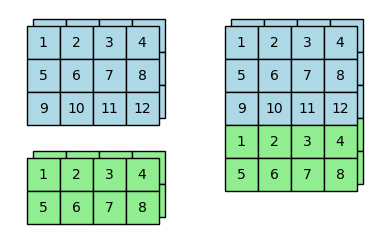

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))

# 왼쪽 상단 어레이
draw(a, ax=ax)

# 왼쪽 하단 어레이
draw(b,
     origin=(0, a.shape[1] + 1),
     rect_kwargs=dict(facecolor='lightgreen')
    )

# 오른쪽 병합 어레이
acolor = np.broadcast_to('lightblue', a.shape)
bcolor = np.broadcast_to('lightgreen', b.shape)
ccolor = np.concatenate((acolor, bcolor), axis=1)

draw(c, 
     origin=(a.shape[2] + 2, 0), 
     rect_kwargs=dict(facecolor=ccolor)
    )

ax.set_aspect(1)
ax.invert_yaxis()
ax.set_axis_off()

plt.tight_layout()
plt.show()

**예제 2**

다음 7 개의 어레이를 타이틀과 함께 그린다.

In [9]:
a, b, c, d = [np_example(shape) for shape in [(2, 3, 4), (2, 2, 4), (2, 3, 2), (2, 3, 4)]]
e = np.concatenate((a, b), axis=1)
f = np.concatenate((a, c), axis=2)
g = np.concatenate((a, d), axis=0)

네 개의 어레이 각각에 사용되는 색상은 다음과 같다.

In [10]:
colors = ['#ffe5b6', '#add8a3', '#c5dbfb', '#efd0dd']

- 어레이 목록

In [11]:
arrs = [a, b, e,
        c, d, None,
        f, None, g]

- 어레이 각각의 모양과 동일한 색상 어레이 지정

In [12]:
a_, b_, c_, d_ = [np.broadcast_to(c, ar.shape) for c, ar in zip(colors, [a, b, c, d])]
colors = [a_, b_, np.concatenate((a_, b_), axis=1),
          c_, d_, None,
          np.concatenate((a_, c_), axis=2), None, np.concatenate((a_, d_), axis=0)]

- 어레이 각각의 타이틀 지정

In [13]:
titles = ['a', 'b', 'np.concatenate((a, b), axis=1)',
          'c', 'd', None,
          'np.concatenate((a, c), axis=2)', None, 'np.concatenate((a, d), axis=0)']

In [14]:
x_pos = np.array((0, 5.5, 12))
y_pos = np.array((0, 4.5, 10))

origins = np.c_[np.meshgrid(x_pos, y_pos)].T.reshape(-1, 2)

In [15]:
origins

array([[ 0. ,  0. ],
       [ 0. ,  4.5],
       [ 0. , 10. ],
       [ 5.5,  0. ],
       [ 5.5,  4.5],
       [ 5.5, 10. ],
       [12. ,  0. ],
       [12. ,  4.5],
       [12. , 10. ]])

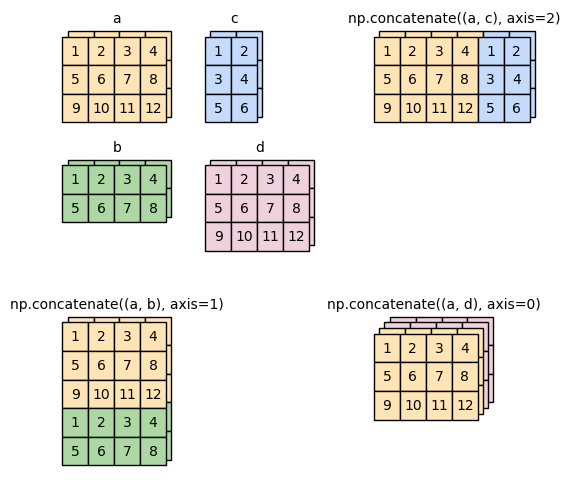

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

for ar, color, title, origin in zip(arrs, colors, titles, origins):
    if ar is None:
        continue
    
    bb = draw(ar, origin=origin, rect_kwargs=dict(facecolor=color))
    
    cc = np.array(bb.coefs['S'])
    txt_xy = np.diagonal(np.c_[1-cc, cc] @ bb.get_points())
    
    ax.annotate(title, txt_xy, xytext=(0, 4), textcoords='offset points', ha='center', va='bottom')

ax.set_aspect(1.1)
ax.invert_yaxis()
ax.set_axis_off()

plt.tight_layout()
plt.show()